# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

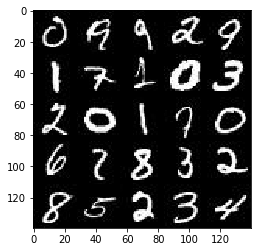

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

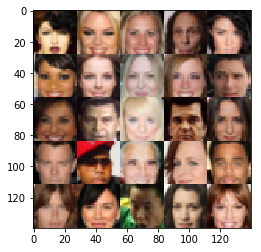

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    patch = 5
    stride = 2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x1 = tf.layers.conv2d(images, 64, patch, strides=stride, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, patch, strides=stride, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        #x3 = tf.layers.conv2d(relu2, 256, patch, strides=stride, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        #Hoping TF pads to 4 otherwise 3.5 x 3.5 x 256
        
        #Flatten her up
        #flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.reshape(relu3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    patch = 5
    stride = 2
    with tf.variable_scope('generator', reuse=not is_train):
        #Create the fully connected layer
        #x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.layers.dense(z, 7*7*128)
        #reshape
        #x1 = tf.reshape(x1, (-1, 4,4,256))
        x1 = tf.reshape(x1, (-1, 7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #4x4x256
        
        #x2 = tf.layers.conv2d_transpose(x1, 128, patch, strides=stride, padding='same')
        x2 = tf.layers.conv2d_transpose(x1, 64, patch, strides=stride, padding='same')
        #Note - May have to come back here and reshape to 7x7
        #x2 = tf.reshape(x2, (-1, 7,7,128))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x128
        
        #x3 = tf.layers.conv2d_transpose(x2, 64, patch, strides=stride, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        #14x14x64
        
        #Output layer
        #logits = tf.layers.conv2d_transpose(x3, out_channel_dim, patch, strides=stride, padding='same')
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, patch, strides=stride, padding='same')
        
        #28x28x?
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Perform optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build Model
    #print(data_shape[0])
    img_w, img_h, img_chan = data_shape[1], data_shape[2], data_shape[3]
    inp_real, inp_z, _ = model_inputs(img_w, img_h, img_chan, z_dim)
    d_loss, g_loss = model_loss(inp_real, inp_z, img_chan)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    display_interval = 100
    num_img_to_disp = 25
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                #Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={inp_real: batch_images, inp_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inp_z: batch_z, inp_real: batch_images})
                
                if steps % display_interval == 0:
                    train_loss_d = d_loss.eval({inp_real: batch_images, inp_z: batch_z})
                    train_loss_g = g_loss.eval({inp_z: batch_z})
                    
                    print(  "Epoch: {} of {}".format(epoch_i, epoch_count), 
                            "D-loss: {}".format(train_loss_d),
                            "G-loss: {}".format(train_loss_g) )
                    
                    show_generator_output(sess, num_img_to_disp, inp_z, img_chan, data_image_mode)        
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 of 2 D-loss: 1.5241739749908447 G-loss: 1.0808244943618774


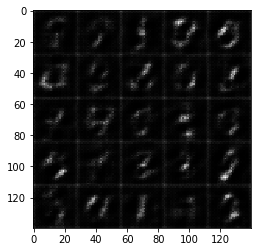

Epoch: 0 of 2 D-loss: 0.8388216495513916 G-loss: 0.8867732882499695


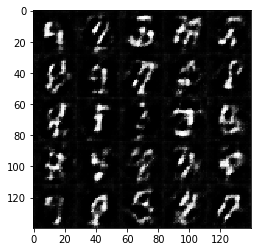

Epoch: 0 of 2 D-loss: 0.8565312623977661 G-loss: 1.141605257987976


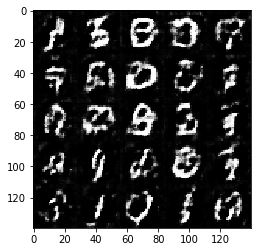

Epoch: 0 of 2 D-loss: 0.6925534605979919 G-loss: 1.870938777923584


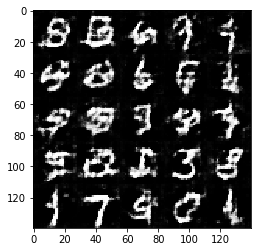

Epoch: 0 of 2 D-loss: 1.5420814752578735 G-loss: 0.3303065299987793


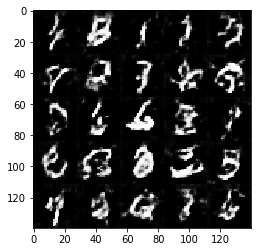

Epoch: 0 of 2 D-loss: 1.2816485166549683 G-loss: 0.5058913230895996


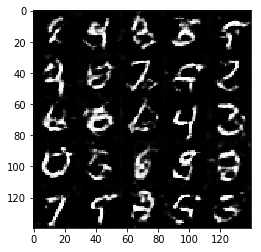

Epoch: 0 of 2 D-loss: 0.5182921290397644 G-loss: 1.758910894393921


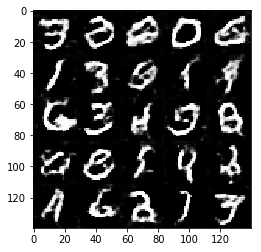

Epoch: 0 of 2 D-loss: 0.6509439945220947 G-loss: 1.361402988433838


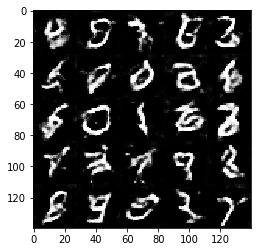

Epoch: 0 of 2 D-loss: 1.1190695762634277 G-loss: 0.605086088180542


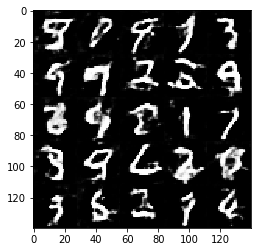

Epoch: 0 of 2 D-loss: 0.7066762447357178 G-loss: 1.0874061584472656


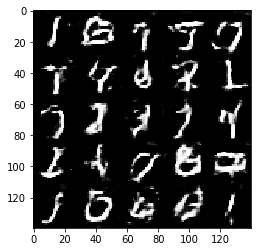

Epoch: 0 of 2 D-loss: 0.9207398295402527 G-loss: 0.6951818466186523


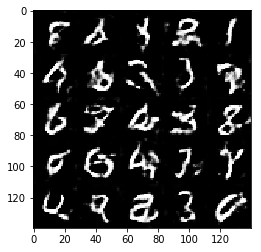

Epoch: 0 of 2 D-loss: 0.9985607266426086 G-loss: 0.7352613210678101


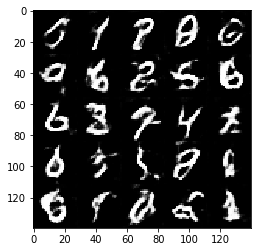

Epoch: 0 of 2 D-loss: 0.6683386564254761 G-loss: 1.0228450298309326


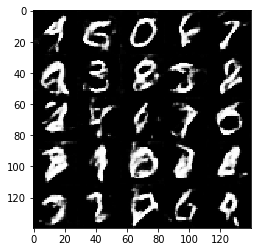

Epoch: 0 of 2 D-loss: 0.6806013584136963 G-loss: 0.9275469779968262


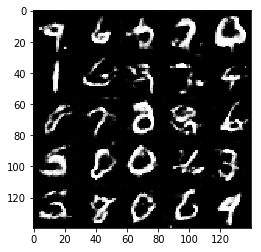

Epoch: 0 of 2 D-loss: 1.3793683052062988 G-loss: 0.3729979991912842


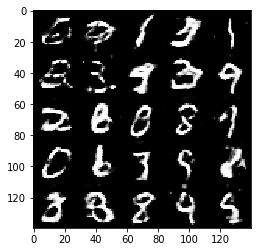

Epoch: 0 of 2 D-loss: 0.9207109808921814 G-loss: 0.9247226715087891


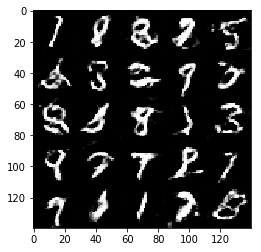

Epoch: 0 of 2 D-loss: 1.191404938697815 G-loss: 0.556297779083252


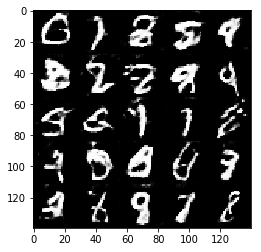

Epoch: 0 of 2 D-loss: 6.396913528442383 G-loss: 0.005635391920804977


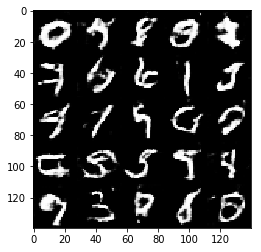

Epoch: 1 of 2 D-loss: 0.8403451442718506 G-loss: 0.8619617223739624


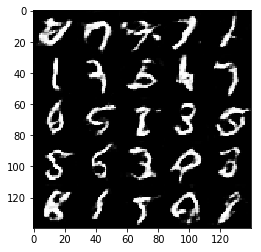

Epoch: 1 of 2 D-loss: 0.515688419342041 G-loss: 1.5837328433990479


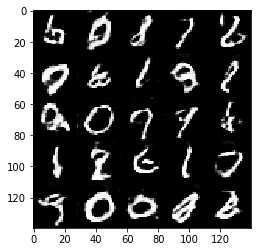

Epoch: 1 of 2 D-loss: 0.4781024158000946 G-loss: 1.2619268894195557


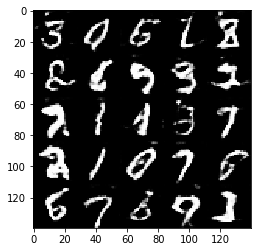

Epoch: 1 of 2 D-loss: 1.0416573286056519 G-loss: 2.732142925262451


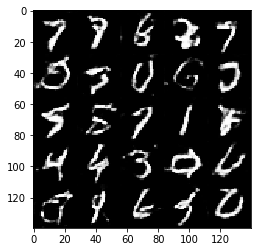

Epoch: 1 of 2 D-loss: 0.9395229816436768 G-loss: 0.9505202174186707


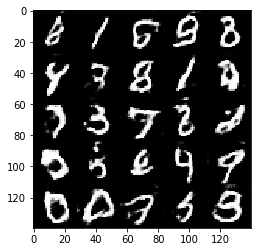

Epoch: 1 of 2 D-loss: 1.563238263130188 G-loss: 8.090456008911133


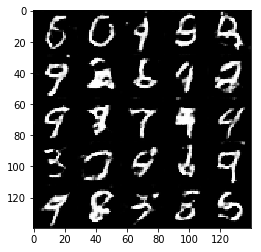

Epoch: 1 of 2 D-loss: 0.6855840086936951 G-loss: 1.1051390171051025


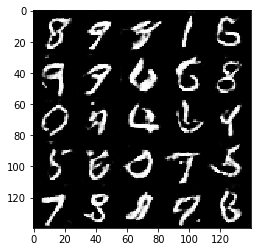

Epoch: 1 of 2 D-loss: 0.5299028158187866 G-loss: 1.3740129470825195


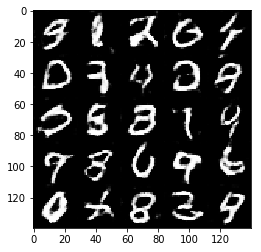

Epoch: 1 of 2 D-loss: 0.9689762592315674 G-loss: 0.6079787015914917


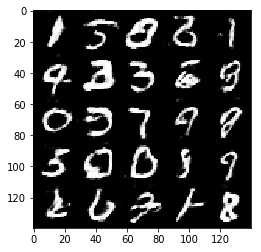

Epoch: 1 of 2 D-loss: 0.6281959414482117 G-loss: 1.3742454051971436


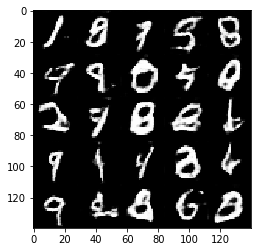

Epoch: 1 of 2 D-loss: 0.32199275493621826 G-loss: 1.7893809080123901


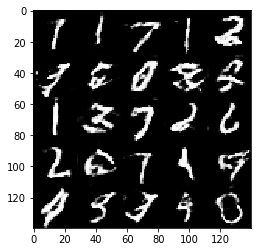

Epoch: 1 of 2 D-loss: 3.974144697189331 G-loss: 6.255815505981445


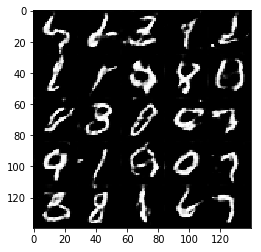

Epoch: 1 of 2 D-loss: 0.650148868560791 G-loss: 1.0315804481506348


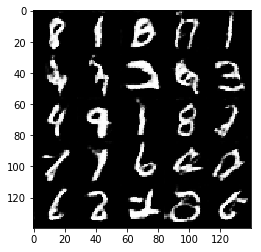

Epoch: 1 of 2 D-loss: 1.089596152305603 G-loss: 0.6366022229194641


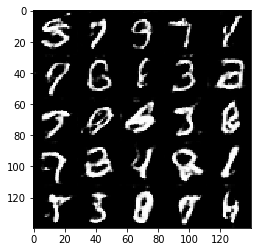

Epoch: 1 of 2 D-loss: 1.3866057395935059 G-loss: 0.5891135931015015


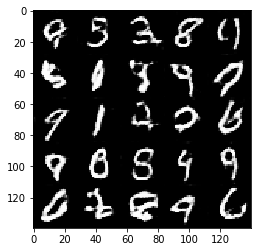

Epoch: 1 of 2 D-loss: 0.8599339127540588 G-loss: 0.8944733142852783


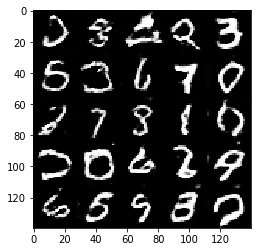

Epoch: 1 of 2 D-loss: 0.3912847638130188 G-loss: 3.63059139251709


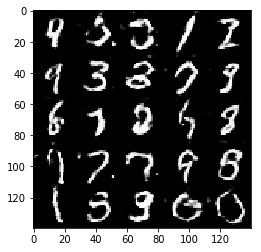

Epoch: 1 of 2 D-loss: 0.9474994540214539 G-loss: 1.7894620895385742


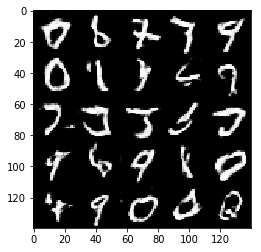

Epoch: 1 of 2 D-loss: 3.56817364692688 G-loss: 0.1628991961479187


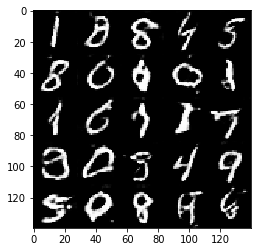

In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 of 1 D-loss: 0.8824518918991089 G-loss: 1.8878278732299805


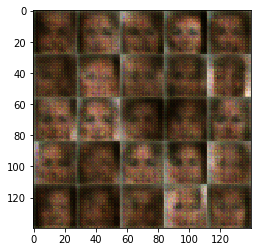

Epoch: 0 of 1 D-loss: 1.2899665832519531 G-loss: 1.6673450469970703


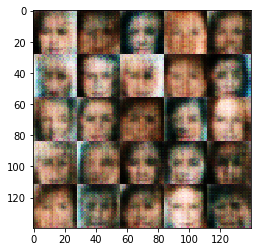

Epoch: 0 of 1 D-loss: 1.0918400287628174 G-loss: 0.7217445373535156


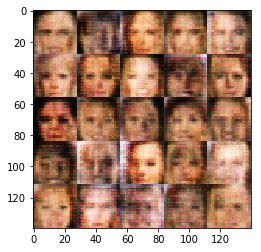

Epoch: 0 of 1 D-loss: 0.9223582744598389 G-loss: 0.5963407754898071


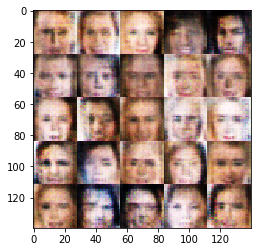

Epoch: 0 of 1 D-loss: 0.6081817150115967 G-loss: 1.4814047813415527


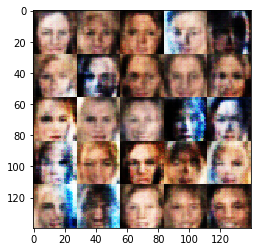

Epoch: 0 of 1 D-loss: 0.38662558794021606 G-loss: 1.98423433303833


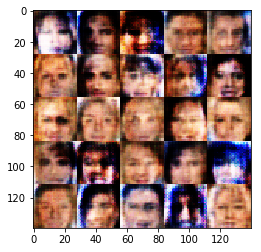

Epoch: 0 of 1 D-loss: 0.6144000887870789 G-loss: 1.0350801944732666


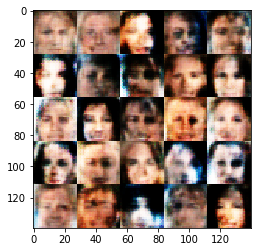

Epoch: 0 of 1 D-loss: 1.0585503578186035 G-loss: 1.1298189163208008


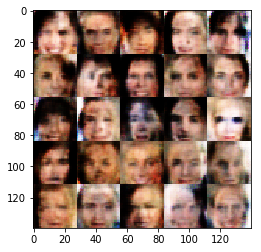

Epoch: 0 of 1 D-loss: 1.241243839263916 G-loss: 0.5175889730453491


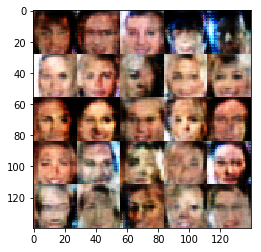

Epoch: 0 of 1 D-loss: 1.1544454097747803 G-loss: 0.9233289957046509


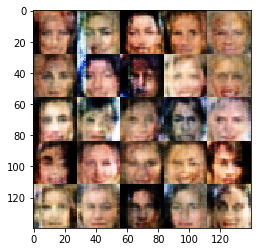

Epoch: 0 of 1 D-loss: 0.9949791431427002 G-loss: 0.7469873428344727


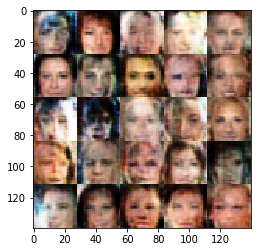

Epoch: 0 of 1 D-loss: 1.2390018701553345 G-loss: 0.4551941156387329


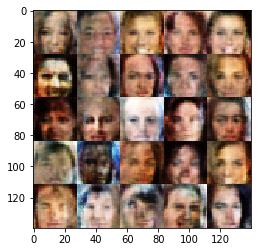

Epoch: 0 of 1 D-loss: 0.8342499136924744 G-loss: 1.1958085298538208


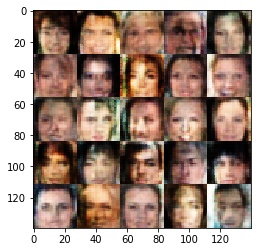

Epoch: 0 of 1 D-loss: 0.9578827619552612 G-loss: 0.7887920141220093


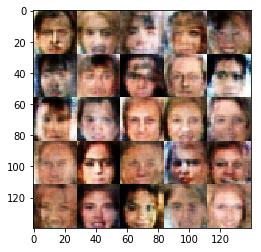

Epoch: 0 of 1 D-loss: 1.1200382709503174 G-loss: 1.0209712982177734


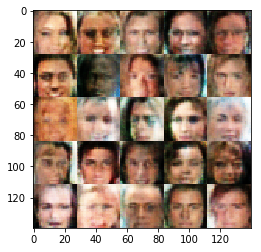

Epoch: 0 of 1 D-loss: 0.8991832733154297 G-loss: 1.0375704765319824


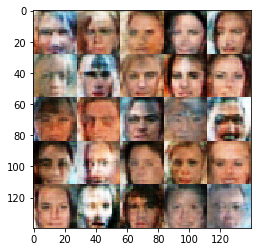

Epoch: 0 of 1 D-loss: 1.085680365562439 G-loss: 0.7879875898361206


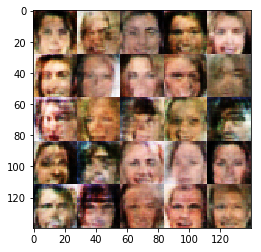

Epoch: 0 of 1 D-loss: 0.7768718004226685 G-loss: 1.2610474824905396


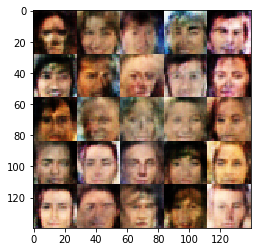

Epoch: 0 of 1 D-loss: 0.971762478351593 G-loss: 1.2849912643432617


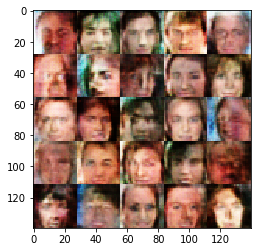

Epoch: 0 of 1 D-loss: 1.7359310388565063 G-loss: 0.2522788941860199


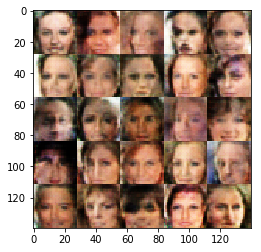

Epoch: 0 of 1 D-loss: 0.8386849164962769 G-loss: 0.8777573108673096


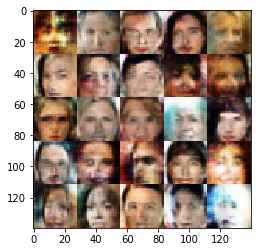

Epoch: 0 of 1 D-loss: 1.1038299798965454 G-loss: 0.7078980803489685


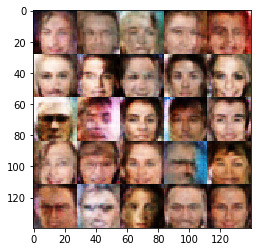

Epoch: 0 of 1 D-loss: 0.8325331211090088 G-loss: 1.7282288074493408


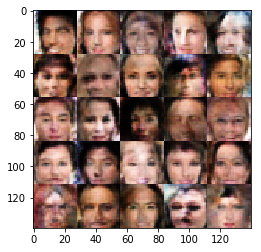

Epoch: 0 of 1 D-loss: 0.6887227892875671 G-loss: 1.4611865282058716


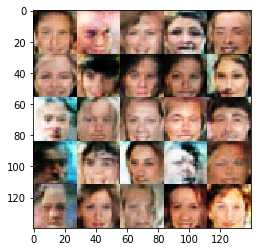

Epoch: 0 of 1 D-loss: 1.044747233390808 G-loss: 2.3515827655792236


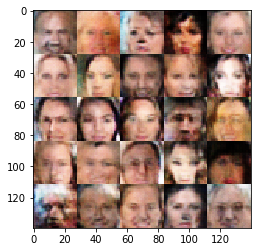

Epoch: 0 of 1 D-loss: 1.4735620021820068 G-loss: 0.33373546600341797


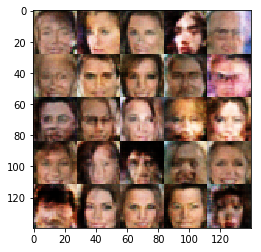

Epoch: 0 of 1 D-loss: 1.3466824293136597 G-loss: 0.4042809307575226


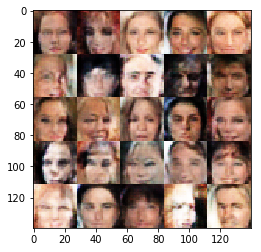

Epoch: 0 of 1 D-loss: 1.0792993307113647 G-loss: 0.569145679473877


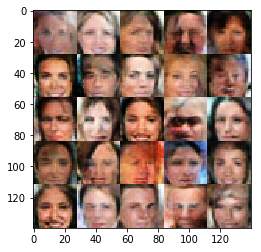

Epoch: 0 of 1 D-loss: 2.7847862243652344 G-loss: 3.069120407104492


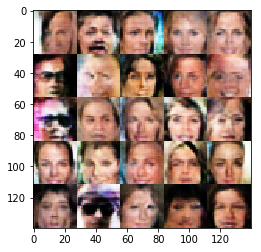

Epoch: 0 of 1 D-loss: 0.7291195392608643 G-loss: 1.2085871696472168


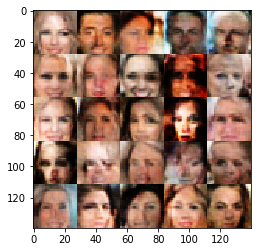

Epoch: 0 of 1 D-loss: 0.31929945945739746 G-loss: 1.9368302822113037


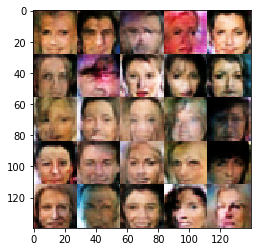

Epoch: 0 of 1 D-loss: 0.336214154958725 G-loss: 3.3775570392608643


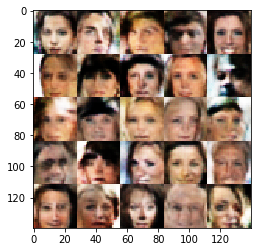

Epoch: 0 of 1 D-loss: 1.8236163854599 G-loss: 2.875690460205078


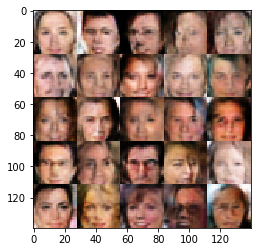

Epoch: 0 of 1 D-loss: 0.23508808016777039 G-loss: 2.0971713066101074


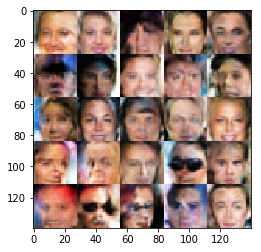

Epoch: 0 of 1 D-loss: 0.40257519483566284 G-loss: 3.1649703979492188


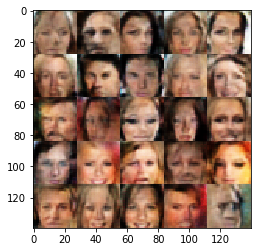

Epoch: 0 of 1 D-loss: 1.2779951095581055 G-loss: 4.482789993286133


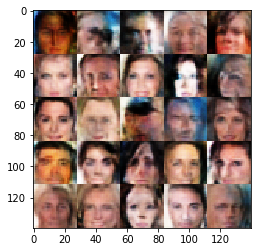

Epoch: 0 of 1 D-loss: 0.7585358619689941 G-loss: 0.7755415439605713


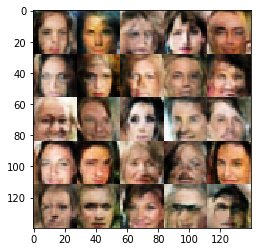

Epoch: 0 of 1 D-loss: 0.21225053071975708 G-loss: 2.5424184799194336


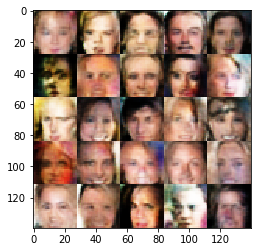

Epoch: 0 of 1 D-loss: 0.0861237421631813 G-loss: 4.327396869659424


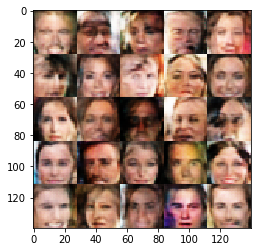

Epoch: 0 of 1 D-loss: 0.3849785625934601 G-loss: 3.1101527214050293


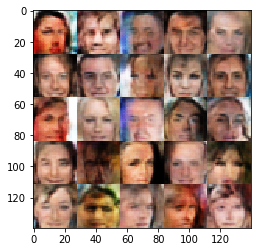

Epoch: 0 of 1 D-loss: 0.991951584815979 G-loss: 0.6768386960029602


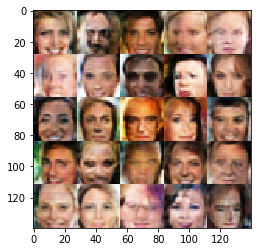

Epoch: 0 of 1 D-loss: 0.45689645409584045 G-loss: 1.5605275630950928


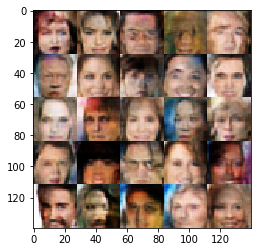

Epoch: 0 of 1 D-loss: 0.3087555468082428 G-loss: 1.9508110284805298


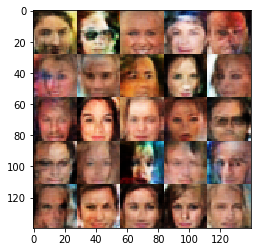

Epoch: 0 of 1 D-loss: 0.48300179839134216 G-loss: 2.99932861328125


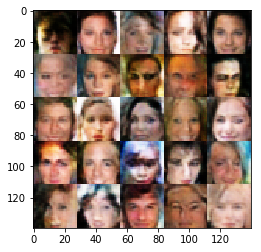

Epoch: 0 of 1 D-loss: 0.7562360167503357 G-loss: 1.0075349807739258


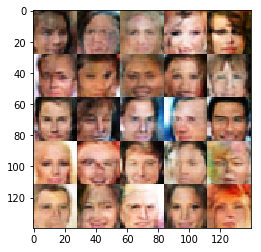

Epoch: 0 of 1 D-loss: 0.41262203454971313 G-loss: 1.4018068313598633


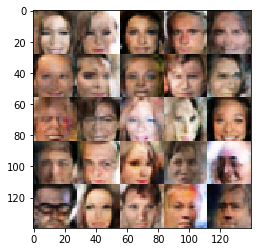

Epoch: 0 of 1 D-loss: 0.04416424036026001 G-loss: 4.414117336273193


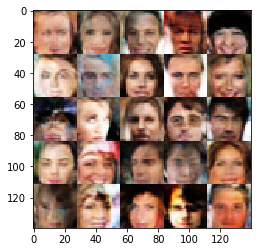

Epoch: 0 of 1 D-loss: 0.9104107022285461 G-loss: 0.7368831038475037


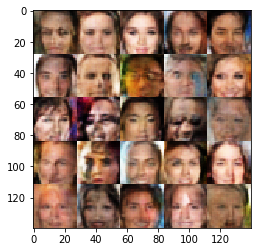

Epoch: 0 of 1 D-loss: 1.8404583930969238 G-loss: 0.28631526231765747


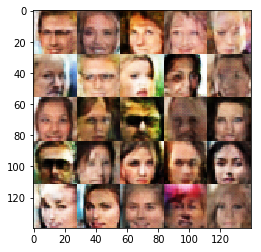

Epoch: 0 of 1 D-loss: 0.12873859703540802 G-loss: 3.221074104309082


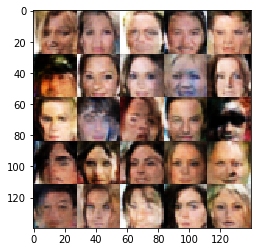

Epoch: 0 of 1 D-loss: 0.1756424456834793 G-loss: 3.560507297515869


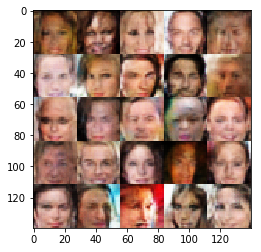

Epoch: 0 of 1 D-loss: 0.2390151023864746 G-loss: 2.421238422393799


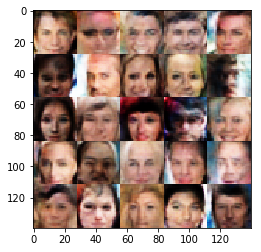

Epoch: 0 of 1 D-loss: 0.37676727771759033 G-loss: 2.611624002456665


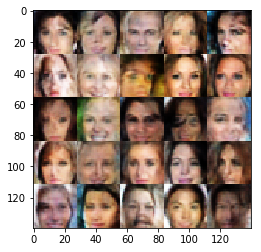

Epoch: 0 of 1 D-loss: 4.497344970703125 G-loss: 5.947843074798584


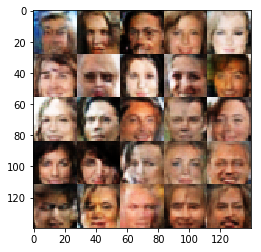

Epoch: 0 of 1 D-loss: 1.2588406801223755 G-loss: 5.80409049987793


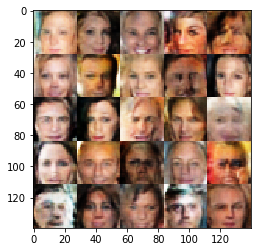

Epoch: 0 of 1 D-loss: 0.3454391360282898 G-loss: 3.3273797035217285


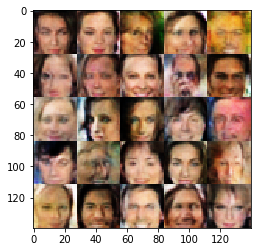

Epoch: 0 of 1 D-loss: 0.05139729380607605 G-loss: 4.556890487670898


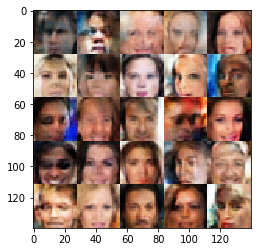

Epoch: 0 of 1 D-loss: 0.4339179992675781 G-loss: 2.2499136924743652


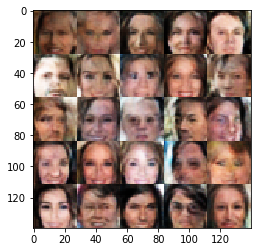

Epoch: 0 of 1 D-loss: 0.09382788836956024 G-loss: 3.9071340560913086


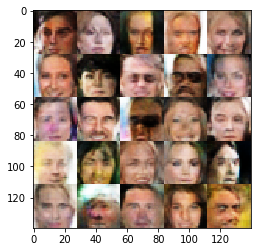

Epoch: 0 of 1 D-loss: 0.15045902132987976 G-loss: 2.5273163318634033


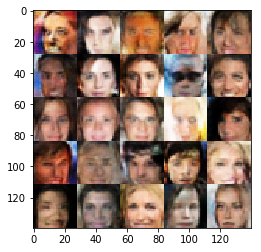

Epoch: 0 of 1 D-loss: 0.5126218795776367 G-loss: 2.1273252964019775


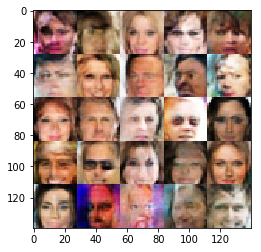

Epoch: 0 of 1 D-loss: 0.0439487025141716 G-loss: 5.749241828918457


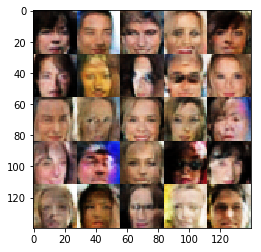

Epoch: 0 of 1 D-loss: 0.2019459307193756 G-loss: 2.5487313270568848


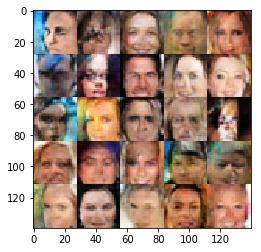

In [37]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.